# Oral microbiota before and after toothbrushing

This re-visualizes the oral microbiome dataset used in [Morton and Marotz et al. 2019](https://www.nature.com/articles/s41467-019-10656-5). Just to review, this is a 16S rRNA sequencing dataset spanning 32 samples.

The main goal of this figure is demonstrating the ease of loading multiple layers of differential abundance measurements onto an EMPress tree, allowing us to do things like quickly see how different differential abundance tools agree or disagree.

## Requirements
This should be run from within a QIIME 2 (at least version 2019.10) conda environment, with EMPress installed. Please see [EMPress' README](https://github.com/biocore/empress) for the most up-to-date installation instructions. The final section of this notebook (generating a scatterplot for the supplement) will require matplotlib to be installed -- this should already be included in QIIME 2 conda environments as of writing, but if this changes in the future then you may need to manually install matplotlib.

## 0. Input data files
The data we'll be using comes primarily from [this GitHub repository](https://github.com/knightlab-analyses/reference-frames) containing the Morton/Marotz paper's data.

### 0.1. Downloaded from [the `data/` folder of the reference frames repository](https://github.com/knightlab-analyses/reference-frames/tree/master/data)

- `oral_trimmed_deblur.biom`: Feature table for this dataset. The features described in this table are a subset of the features in `rep-seqs-deblur.qza`, indicating that some filtering was likely done upstream. (This table is not stored as a QIIME 2 artifact, so we don't have provenance data for it.)

- `oral_trimmed_metadata.txt`: Sample metadata for this dataset.

- `deblur-taxonomy.qza`: Taxonomy for this dataset, assigned using q2-feature-classifier's `classify-sklearn` method.

### 0.2. Downloaded from [the `results/oral-results/` folder of the reference frames repository](https://github.com/knightlab-analyses/reference-frames/tree/master/results/oral-results)

(These are the three differential abundance tools' results we'll be visualizing on the tree.)

- `differentials.csv`: Songbird differentials
- `aldex2_results.txt`: ALDEx2 results, including per-feature effect sizes and adjusted p-values
- `ancom_results_mixed.csv`: ANCOM results, including W statistics and whether or not features were significant at certain cutoffs.

### 0.3. Not downloaded from GitHub

- `rep-seqs-deblur.qza`: Sequences for this dataset, produced using Deblur. This artifact was not included in the `reference-frames` GitHub repo, although thanks to QIIME 2's provenance tracking we can verify that this artifact's UUID (`0af26274-7003-4be1-abbf-255c03a6ef9c`) matches the UUID of the sequences from which `deblur-taxonomy.qza` was generated.

For the sake of convenience, we've included all input files in the `notebooks/fig2c/input/` folder within this repository.

## 1. Prepare data

### 1.1. Import feature table
The feature table for this dataset (`fig2c/input/oral_trimmed_deblur.biom`) is just stored as a BIOM table. To use it with QIIME 2, we'll need to "import" it (see the [QIIME 2 docs](https://docs.qiime2.org/2020.8/tutorials/importing/) for details on why this is needed).

In [105]:
!qiime tools import \
    --type "FeatureTable[Frequency]" \
    --input-path fig2c/input/oral_trimmed_deblur.biom \
    --output-path fig2c/output/table.qza

Imported fig2c/input/oral_trimmed_deblur.biom as BIOMV210DirFmt to fig2c/output/table.qza


### 1.2. Load and prepare differential abundance results

First off, we need to convert things so that all of these methods use tab delimiters instead of commas or spaces -- this is because QIIME 2 generally expects all metadata files to be tab-separated.

Also, we'll need to merge all of the differential abundance results into a single DataFrame. It's possible to pass multiple feature metadata files to QIIME 2 and have it do the merging automatically, but currently an "inner join" merge is used -- this can result in a lot of features being dropped if just one of the metadata files only contains entries for some features (see [this issue](https://github.com/biocore/empress/issues/393) for details). For us, this can cause problems because Songbird filters out a few features (although ALDEx2 and ANCOM did not). To get around this, we just do the merging ourselves.

#### 1.2.1. Songbird
See [here](https://github.com/knightlab-analyses/reference-frames/blob/master/scripts/oral-multinomial.sh) for the script that was presumably used to generate these results.

In [1]:
import pandas as pd

sb = pd.read_csv("fig2c/input/differentials.csv", sep=",", index_col=0)

sb.head()

,Intercept,C(brushing_event)[T.before]
99647b51f775c8ddde8ed36a7d60dbcd,4.353183,1.105140
51121722488d0c3da1388d1b117cd239,4.564780,0.797395
d599ebe277afb0dfd4ad3c2176afc50e,3.638733,0.466282
39c4199fe81f30a5b4b0fd5bf2f43c03,3.567794,-0.036673
4629fbb5dde5f8ee07c2259d2887a8d4,2.803713,0.326921


#### 1.2.2. ALDEx2

See [here](https://github.com/knightlab-analyses/reference-frames/blob/master/scripts/aldex2_oral_analysis.R) for the script that was presumably used to generate these results.

In [2]:
aldex2 = pd.read_csv("fig2c/input/aldex2_results.txt", sep=" ", index_col=1)
# Many of the feature IDs erroneously start with X -- this is due to R, see
# https://stackoverflow.com/a/10444744/10730311. To get around this, we remove all leading Xs
# (this is safe because all of the feature IDs seem to have only lowercase alphabetical characters,
# so the only instances of Xs should be at the start of the IDs)
aldex2.index = [i if i[0] != 'X' else i[1:] for i in aldex2.index]
aldex2.head()

,sfit.category,sfit.effect,sfit.padj
99647b51f775c8ddde8ed36a7d60dbcd,1,0.853597,0.132165
51121722488d0c3da1388d1b117cd239,2,0.599897,0.448483
d599ebe277afb0dfd4ad3c2176afc50e,3,0.185457,0.859527
39c4199fe81f30a5b4b0fd5bf2f43c03,4,0.234499,0.927057
4629fbb5dde5f8ee07c2259d2887a8d4,5,0.235738,0.892176


#### 1.2.3. ANCOM

See [here](https://github.com/knightlab-analyses/reference-frames/blob/master/scripts/ancom_oral_analysis.R) for the script that was presumably used to generate these results.

In [3]:
ancom = pd.read_csv("fig2c/input/ancom_results_mixed.csv", sep=",", index_col=0)
# Just like with ALDEx2, remove leading Xs
ancom.index = [i if i[0] != 'X' else i[1:] for i in ancom.index]
ancom.head()

,W_stat,detected_0.9,detected_0.8,detected_0.7,detected_0.6
f6eb8537456dde7792eff60c8d1e797c,201,True,True,True,True
1275c8657f3502d2f3d7b0d9ec7e1c78,188,True,True,True,True
a9b4a380d3b76755de55410a3b856df4,187,True,True,True,True
41f67443ce8207be0c0a956c47823417,180,False,True,True,True
99647b51f775c8ddde8ed36a7d60dbcd,179,False,True,True,True


### 1.3. Merge all the differential abundance results, and export the resulting file
Note that we filter out the 9 features present in the ALDEx2 and ANCOM results but not in the Songbird results.

In [4]:
# We use join="inner" to filter this to just the features shared across all DataFrames
diff = pd.concat([sb, aldex2, ancom], axis=1, sort=False, join="inner")

# This DataFrame's first column doesn't have a name, so we need to give it a valid
# one to prevent QIIME 2 from yelling at us.
diff.index.name = "FeatureID"

diff.to_csv("fig2c/output/merged-diff-abund.tsv", sep="\t")

diff.head()

,Intercept,C(brushing_event)[T.before],sfit.category,sfit.effect,sfit.padj,W_stat,detected_0.9,detected_0.8,detected_0.7,detected_0.6
FeatureID,,,,,,,,,,
99647b51f775c8ddde8ed36a7d60dbcd,4.353183,1.105140,1,0.853597,0.132165,179,False,True,True,True
51121722488d0c3da1388d1b117cd239,4.564780,0.797395,2,0.599897,0.448483,106,False,False,False,False
d599ebe277afb0dfd4ad3c2176afc50e,3.638733,0.466282,3,0.185457,0.859527,0,False,False,False,False
39c4199fe81f30a5b4b0fd5bf2f43c03,3.567794,-0.036673,4,0.234499,0.927057,6,False,False,False,False
4629fbb5dde5f8ee07c2259d2887a8d4,2.803713,0.326921,5,0.235738,0.892176,19,False,False,False,False


#### 1.3.1. Inspect the features that Songbird filtered out

**I'm not sure why these nine features were filtered out.** Songbird does filter out features present in less than a given number of samples—10 samples is Songbird's default `min-feature-count` parameter as of writing, although this has been inconsistent<sup>1</sup> and was until recently impacted by a bug<sup>2</sup>. However, this doesn't seem like it was the sole reason for these features being filtered out: the nine features Songbird filtered out are all present in six or seven samples, but these are not the only samples in this table present in this many samples, which is confusing. (We demonstrate this below.) **It seems like some sort of filtering was done on the table we have, since the minimum number of samples a feature is present in is 6.** (And also because the table's features are a already a subset of the rep seqs, as described earlier.)

For the sake of simplicity, we'll just go forward with Songbird's results, filtering out these nine features from the dataset. The goal of this (sub)figure is mostly just demonstrating the ability to show all of these differential abundance methods simultaneously, rather than digging into the nitty-gritty of any one of them. For a more in-depth analysis of this data, we'd probably want to start from raw reads (or at least the processed data on Qiita) and then analyze that, rather than relying on old files without provenance.

> "Microbiome data analysis is hard. Sometimes it do be like that." - Aristotle, probably

##### Footnotes

<sup>1</sup>In old versions of Songbird, the default `min-feature-count` parameter for "standalone" (i.e. not run through QIIME 2) Songbird was 5 samples, instead of 10 samples. This was fixed in a July 2019 commit [here](https://github.com/biocore/songbird/commit/237cca7e4fce28edcfe8a89ba71aed0778b216d2#diff-ea06a974407d62771a0b14a67103684bfb741ff3b5ef860c11ab3f2794ca0bd4).

<sup>2</sup>Until recently (fixed in Songbird 1.0.4, released November 2020), there was an [off-by-one bug](https://github.com/biocore/songbird/issues/139) with the filtering values.

In [21]:
from qiime2 import Artifact
tbl = Artifact.load("fig2c/output/table.qza").view(pd.DataFrame)

# Double-check that ALDEx2 and ANCOM's results include all the features in the table
assert set(aldex2.index) == set(ancom.index) == set(tbl.columns)

# These are just the nine features not present in Songbird's output
sb_filtered_features = set(aldex2.index) - set(sb.index)

# Convert the table to presence/absence: replace nonzero values with a 1, indicating that for this
# (feature, sample) cell, the feature is present in this sample
tbl_pa = tbl.where(lambda v: v == 0, 1)

# Compute the sum for each feature (i.e. how many samples were these features observed in?)
feature_sample_counts = tbl_pa.sum()

# Filter to just the features Songbird filtered out: see how many samples these features are present in
feature_sample_counts[sb_filtered_features]

7a3c53a016c89d53c85edd54abf40554    6.0
8684b6a7961c0992abe42d81c59468d4    7.0
ff87795cecc4edbc180c779cefee28b1    6.0
dca4fd44687cf8eaf0bd364de904dc91    6.0
5c5fb3e43d7509b532cb4aea6a521bbb    6.0
379d8b315627c1476d03fc5e5a110f3a    7.0
48b7da424fc877aacae135d0608f7277    7.0
ed69dfdb9f2daf0a582431aebc1a6a6c    6.0
7eb7a384d6ef9f24cf2abe6a53bf7860    6.0
dtype: float64

We can see that all of the Songbird-filtered features are present in just 6 or 7 samples. Let's see if these are the only features present in 6 or 7 samples, or if other features in the table are also present in 6 or 7 samples.

In [20]:
non_filtered_feature_sample_counts = feature_sample_counts[set(sb.index)]
non_filtered_feature_sample_counts.sort_values()

76355427db027e5ec9f4404f906613a1     6.0
5f66e02cbec2e0fd5d17767796a97ca9     6.0
855737ee127d6ae254fc2900a29004fc     6.0
7f7e45fb16bc75b08d60ac5d15841412     6.0
501fbc1d4cafee319b7e930393cd1b48     6.0
                                    ... 
9825426be20fbb54b2a7f72ee7d48d21    32.0
51121722488d0c3da1388d1b117cd239    32.0
8f0ba2d0c4a91f9303ab9e1b48d9f92b    32.0
80e2a0cdbbf0ae81a93b6ba374faeb14    32.0
d3a5dac580af1f9ccc6f516d334454c5    32.0
Length: 195, dtype: float64

OK, so now we can see that there are other features that _weren't filtered out by Songbird_ and yet are present in just as many samples in the table—for example, `76355427db027e5ec9f4404f906613a1`, which is just present in 6 samples. It is therefore unclear _why_ the Songbird differentials do not include the nine features discussed here, as described above.

### 1.4. Filter the data: both removing the nine features not in the Songbird differentials, and removing the features in `rep-seqs.qza` but not in the table

It is worth noting that the sequences described in the table are a subset of the sequences contained in `rep-seqs-deblur.qza`, as mentioned earlier. There are two ways to handle this situation (well, aside from making a new table that didn't use filtering, but at that point we'd probably have to regenerate the differential abundance results here):

1. Generate a tree from _all_ of the sequences, regardless of whether or not they are included in the table, and then pass in the table to EMPress. By default, EMPress will shear the tree to just the sequences contained in the table. (This behavior is configurable with the `--p-shear-tree` parameter of `qiime empress community-plot`.)

2. Filter the sequences down to just those in the table, and then generate a tree from _those_ sequences.

Either solution would "work," in the sense that it'd let us visualize the putative relationships between sequences. We'll go ahead and take option number 2, since it seems like the most straightforward way to handle this.

We also need to filter out the nine features in the table that are _not_ present in the differential abundance data (due to being filtered out by Songbird, as described in painful detail above). We'll do that first.

#### 1.4.1. Filter the table to just features present in the differential abundance results

In [111]:
!qiime feature-table filter-features \
    --i-table fig2c/output/table.qza \
    --m-metadata-file fig2c/output/merged-diff-abund.tsv \
    --o-filtered-table fig2c/output/filtered-table.qza

Saved FeatureTable[Frequency] to: fig2c/output/filtered-table.qza


#### 1.4.2. Filter the sequences to just those present in the now-filtered table

In [112]:
!qiime feature-table filter-seqs \
    --i-data fig2c/input/rep-seqs-deblur.qza \
    --i-table fig2c/output/filtered-table.qza \
    --o-filtered-data fig2c/output/filtered-rep-seqs.qza

Saved FeatureData[Sequence] to: fig2c/output/filtered-rep-seqs.qza


### 1.5. Generate a phylogenetic tree from the (filtered) data

Before we can visualize a tree, we need to have a tree :)

There are many ways we can do this, but here we don't care too much about the details -- we'll just create a _de novo_ tree from the sequences, which is fortunately simple to do using QIIME 2's `qiime phylogeny align-to-tree-mafft-fasttree` pipeline.

This pipeline generates a bunch of different outputs, so we just create a new subdirectory (`filtered-denovo-tree/`) within the output directory to store the results in.

Note that this command will generate both an unrooted and a rooted tree. EMPress requires that the input tree is rooted, so we'll visualize the `Phylogeny[Rooted]` tree. (That said, EMPress can still lay out the tree in an unrooted manner.)

In [113]:
# QIIME 2 doesn't allow overwriting output directories, so we remove the previous output
# directory if if exists before (re)-running this command.
!rm -rf fig2c/output/filtered-denovo-tree/

!qiime phylogeny align-to-tree-mafft-fasttree \
    --i-sequences fig2c/output/filtered-rep-seqs.qza \
    --output-dir fig2c/output/filtered-denovo-tree/

Saved FeatureData[AlignedSequence] to: fig2c/output/filtered-denovo-tree/alignment.qza
Saved FeatureData[AlignedSequence] to: fig2c/output/filtered-denovo-tree/masked_alignment.qza
Saved Phylogeny[Unrooted] to: fig2c/output/filtered-denovo-tree/tree.qza
Saved Phylogeny[Rooted] to: fig2c/output/filtered-denovo-tree/rooted_tree.qza


## 2. Visualize the prepared data in the context of the tree

Finally!

### 2.1. Generate the visualization using EMPress

#### Why `community-plot`?

We visualize this tree using `qiime empress community-plot`, which takes as input (in addition to the tree and feature metadata) a feature table and sample metadata files.

We don't _need_ to do this -- for Fig. 2(C), we only visualize feature metadata, so we could instead use `qiime empress tree-plot` and avoid providing the feature table and sample metadata to EMPress. However, it can still be useful to pass this data to EMPress if you have it: here, it lets us do fun things like create barplots showing the split between `before`- and `after`- brushing samples for each tip (which we didn't include in the paper for the sake of space, but is still interesting).

In [114]:
!qiime empress community-plot \
    --i-tree fig2c/output/filtered-denovo-tree/rooted_tree.qza \
    --i-feature-table fig2c/output/filtered-table.qza \
    --m-sample-metadata-file fig2c/input/oral_trimmed_metadata.txt \
    --m-feature-metadata-file fig2c/input/deblur-taxonomy.qza \
    --m-feature-metadata-file fig2c/output/merged-diff-abund.tsv \
    --o-visualization fig2c/output/tree-viz.qzv

# Alternately:
# !qiime empress tree-plot \
#     --i-tree fig2c/output/filtered-denovo-tree/rooted_tree.qza \
#     --m-feature-metadata-file fig2c/input/deblur-taxonomy.qza \
#     --m-feature-metadata-file fig2c/output/merged-diff-abund.tsv \
#     --o-visualization fig2c/output/tree-viz-just-fm.qzv

Saved Visualization to: fig2c/output/tree-viz.qzv


### 2.2. Customize the visualization to match Fig. 2(C) in the paper

Instructions for doing this are located in the [README for this repository](https://github.com/knightlab-analyses/empress-analyses).

## 3. Visualize the same differential abundance data using a scatterplot (for the supplement)
Just to demonstrate that Songbird and ALDEx2's results are roughly correlated, and that ANCOM's W-statistic lacks the "directionality" inherent to the other two methods' results.

(Note that more recent versions of ANCOM can generate output that is more similar to these other results, e.g. in fold-change units -- so this figure shouldn't be interpreted as us trying to dunk on ANCOM. It's moreso just saying "hey, this is what the data looks like." The main reason we've used these slightly old results is so we can reuse the data from Morton/Marotz et al. 2019.)

195 features contained in the DataFrame.


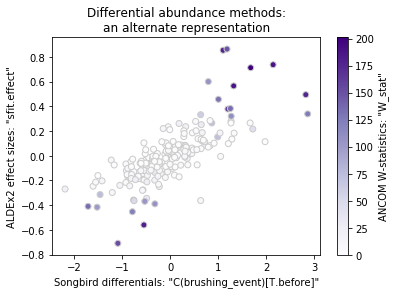

In [115]:
import pandas as pd
from matplotlib import pyplot

df = pd.read_csv("fig2c/output/merged-diff-abund.tsv", sep="\t", index_col=0)
print("{} features contained in the DataFrame.".format(len(df.index)))

# https://matplotlib.org/gallery/lines_bars_and_markers/scatter_demo2.html
fig, ax = pyplot.subplots()

scatter = ax.scatter(
    # x-axis: Songbird differentials
    df["C(brushing_event)[T.before]"],
    # y-axis: ALDEx2 effect sizes
    df["sfit.effect"],
    # color by ANCOM W-statistics
    c=df["W_stat"],
    # (Use the same color map as in EMPress. There may be slight differences in how EMPress and matplotlib
    # do interpolation, because I haven't really dug into matplotlib's codebase, but the results should be
    # roughly the same.)
    cmap="Purples",
    # Add a light border around points in the scatterplot. The main use of this is that it makes the
    # white points in the middle-ish of the plot much easier to see.
    edgecolors="#cccccc"
)

# Rename labels to be more easily understandable: https://stackoverflow.com/a/31539505/10730311
ax.set_xlabel('Songbird differentials: "C(brushing_event)[T.before]"')
ax.set_ylabel('ALDEx2 effect sizes: "sfit.effect"')

# Thanks to https://stackoverflow.com/q/61084381/10730311 for leading me to this -- apparently you
# need to create a colorbar, not a legend, for showing the color legend here. ...ok.
pyplot.colorbar(scatter).set_label('ANCOM W-statistics: "W_stat"')

ax.set_title("Differential abundance methods:\nan alternate representation")

pyplot.savefig("fig2c/output/diff-abund-scatterplot.svg")

As we can see, Songbird and ALDEx2's results are pretty similar. ANCOM's W-statistics are pretty low for many of the "middle" features (i.e. the ones in the middle of the plot), and get large for many of the more "extreme" points. This corroborates our interpretation of this information overlaid on a tree in Fig. 2(c): these methods are in rough agreement.